### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1_rst.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

,MSP,RST,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,
2015-02-01 00:00:00-05:00,23.00,24.08,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,24.08,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,23.00,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,19.94,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,19.04,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [2]:
features = ['MSP', 'RST', ds.actual]
df = ds.data[features].copy()
load = ds.data[ds.actual].copy().to_numpy()

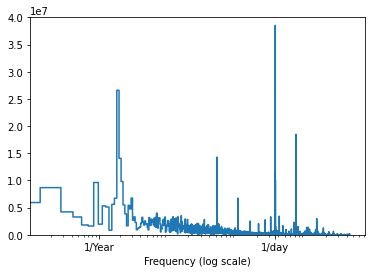

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

fft = tf.signal.rfft(load)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(load)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [4]:
f_per_year[np.argwhere(np.abs(fft) > 1e7).flatten()]

array([  0.        ,   1.95471468,   2.09433716,  52.21880642,
       364.27504266, 365.2524    , 366.22975734, 730.5048    ])

Create yearly, weekly, and daily signals.

In [5]:
import pandas as pd
day = 24*60*60
year = (365.2425)*day
timestamp_s = df.index.to_series().map(pd.Timestamp.timestamp)
df['Daily sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Daily cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Weekly sin'] = np.sin(timestamp_s * (2 * np.pi / (7*day)))
df['Weekly cos'] = np.cos(timestamp_s * (2 * np.pi / (7*day)))
df['Yearly sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Yearly cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

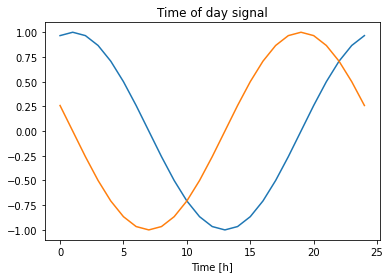

In [6]:
plt.plot(np.array(df['Daily sin'])[:25])
plt.plot(np.array(df['Daily cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [8]:
num_test_samples = num_val_samples = 365 * 24
num_train_samples = df.shape[0] - num_test_samples - num_val_samples

train_df = df.iloc[:num_train_samples]
val_df = df.iloc[num_train_samples:num_train_samples + num_val_samples]
test_df = df.iloc[num_train_samples + num_val_samples:]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

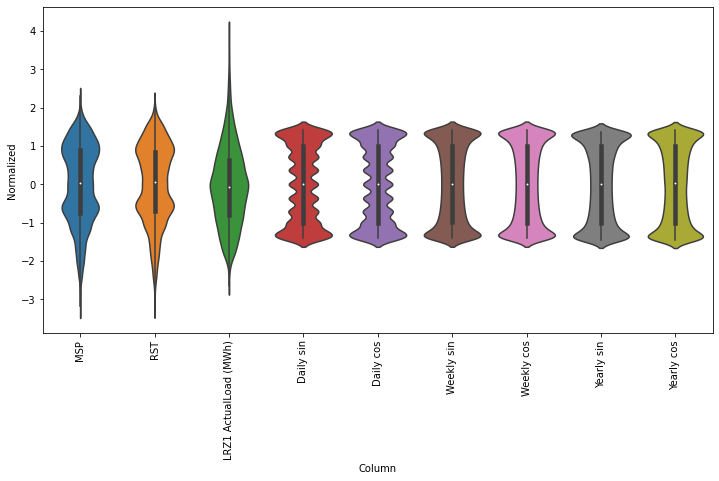

In [10]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [25]:
from validation import WindowGenerator
import tensorflow as tf
from tensorflow import keras
from keras import layers

MAX_EPOCHS = 20

def compile_and_fit(model, window : WindowGenerator, patience=5, optimizer="adamax", loss="mse",
                    epochs=MAX_EPOCHS, checkpoint_file=None):

    ts = datetime.now().strftime ("%Y%m%d_%H%M%S")
    checkpoint_file = checkpoint_file or f"load_prediction_{optimizer}_{loss}_{ts}.keras"
    print(f"Saving checkpoints to {checkpoint_file}")

    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_file, monitor='val_mae', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=patience)]
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])

    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=callbacks)
    model = keras.models.load_model(checkpoint_file)
    print(f"Best model saved to {checkpoint_file}")
    return history


In [36]:
# by default predict a single hour a full day ahead based on previous eight days
def window(input_width=24*8, label_width=1, shift=24, label_columns=[ds.actual]):
    return WindowGenerator(input_width=input_width, label_width=label_width, shift=shift,
                           train_df=train_df, val_df=val_df, test_df=test_df,
                           label_columns=label_columns)

# predict 24 hours based on the previous hour
wide_window = window(input_width=24, label_width=24, shift=1)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['LRZ1 ActualLoad (MWh)']

In [37]:
day_ahead_window = window()
day_ahead_window

Total window size: 216
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191]
Label indices: [215]
Label column name(s): ['LRZ1 ActualLoad (MWh)']

In [19]:
linear = keras.Sequential([
    keras.layers.Dense(units=1)
])
single_step_window = window(input_width=1, label_width=1)
h_l = compile_and_fit(linear, single_step_window)

linear.evaluate(single_step_window.test)

Saving checkpoints to load_prediction_adamax_mse_20220506_110338.keras
Epoch 1/20
1415/1415 [==============================] - 2s 871us/step - loss: 1.9636 - mae: 1.0852 - val_loss: 0.7621 - val_mae: 0.7031
Epoch 2/20
1415/1415 [==============================] - 1s 550us/step - loss: 0.2558 - mae: 0.3897 - val_loss: 0.1324 - val_mae: 0.2960
Epoch 3/20
1415/1415 [==============================] - 1s 564us/step - loss: 0.0595 - mae: 0.1922 - val_loss: 0.0401 - val_mae: 0.1593
Epoch 4/20
1415/1415 [==============================] - 1s 543us/step - loss: 0.0414 - mae: 0.1580 - val_loss: 0.0358 - val_mae: 0.1498
Epoch 5/20
1415/1415 [==============================] - 1s 570us/step - loss: 0.0401 - mae: 0.1554 - val_loss: 0.0349 - val_mae: 0.1480
Epoch 6/20
1415/1415 [==============================] - 1s 586us/step - loss: 0.0396 - mae: 0.1543 - val_loss: 0.0343 - val_mae: 0.1468
Epoch 7/20
1415/1415 [==============================] - 1s 545us/step - loss: 0.0392 - mae: 0.1534 - val_loss: 0.

[0.03525986149907112, 0.1483793407678604]

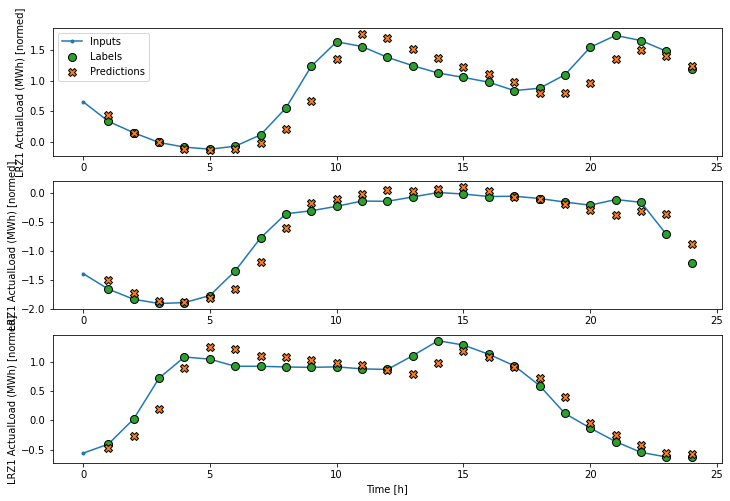

In [26]:
wide_window.plot(linear)

In [ ]:
import numpy as np
from tensorflow import keras

sampling_rate = 1
sequence_length = 24*8
delay = sampling_rate * (sequence_length + 24 - 1) 

batch_size = 32 # hyperparameter
should_shuffle = True



In [30]:
lstm_model = keras.models.Sequential([
    layers.Dense(32, activation='leaky_relu'),
    layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True),
    layers.LSTM(64, unroll=True, recurrent_dropout=0.25, return_sequences=True),
    layers.LSTM(64, unroll=True, recurrent_dropout=0.25),
    layers.Dropout(0.25),
    layers.Dense(32, activation='leaky_relu'),
    layers.Dense(1)
])

In [38]:
history = compile_and_fit(lstm_model, day_ahead_window)


Saving checkpoints to load_prediction_adamax_mse_20220506_120625.keras
Epoch 1/20
1408/1408 [==============================] - 589s 300ms/step - loss: 0.2238 - mae: 0.3583 - val_loss: 0.2378 - val_mae: 0.3786
Epoch 2/20
1408/1408 [==============================] - 544s 386ms/step - loss: 0.1512 - mae: 0.2918 - val_loss: 0.1836 - val_mae: 0.3233
Epoch 3/20
1408/1408 [==============================] - 538s 382ms/step - loss: 0.1371 - mae: 0.2760 - val_loss: 0.1888 - val_mae: 0.3296
Epoch 4/20
1408/1408 [==============================] - 537s 381ms/step - loss: 0.1281 - mae: 0.2661 - val_loss: 0.1772 - val_mae: 0.3155
Epoch 5/20
1408/1408 [==============================] - 539s 383ms/step - loss: 0.1209 - mae: 0.2579 - val_loss: 0.1811 - val_mae: 0.3196
Epoch 6/20
1408/1408 [==============================] - 554s 394ms/step - loss: 0.1157 - mae: 0.2513 - val_loss: 0.1701 - val_mae: 0.3068
Epoch 7/20
1408/1408 [==============================] - 559s 397ms/step - loss: 0.1117 - mae: 0.2472 

NameError: name 'IPython' is not defined

In [39]:

lstm_model.evaluate(day_ahead_window.test, verbose=0)

[0.16323180496692657, 0.3009146749973297]

In [43]:
0.3009146749973297 * train_std[2] + train_mean[2]

11607.366241218118

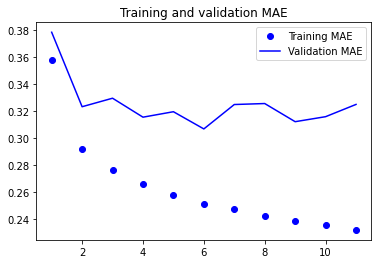

In [44]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()